In [13]:
import numpy as np
import pandas as pd
import lda
import lda.datasets
import pylab as plt
%matplotlib inline

import sys
import os

In [14]:
def get_outfile(results_prefix, binary, doctype):
    if binary:
        parent_dir = 'results/' + results_prefix + '/binary'
        outfile = parent_dir + '/' + results_prefix + '_binary' + doctype
    else:
        parent_dir = 'results/' + results_prefix + '/multinomial'
        outfile = parent_dir + '/' + results_prefix + '_multinomial' + doctype
    if not os.path.exists(parent_dir):
        os.makedirs(parent_dir)        
    return outfile

In [15]:
def run_lda(results_prefix, filename, binary, n_topics):    
        
    data = pd.read_csv(filename,index_col=0)    
    if binary:
        print "Binary input from " + filename
        data = data.replace(np.nan,0)
        data[data>0] = 1
        data = data.transpose()
        npdata = np.array(data,dtype='int64')
    else:
        print "Multinomial input from " + filename
        data = np.log(data)
        min_val = data.min().min()
        data /= data.max().max()
        data *= 100
        from scipy.sparse import coo_matrix
        data = data.replace(np.nan,0)
        data = data.transpose()
        sd = coo_matrix(data)
        plt.hist(sd.data)
        sd = sd.floor()  
        npdata = np.array(sd.todense(),dtype='int64')
    print "Data shape " + str(npdata.shape)

    print "Fitting model..."
    sys.stdout.flush()
    model = lda.LDA(n_topics = n_topics, n_iter=1000, random_state=1)
    model.fit(npdata)
    print "DONE!"
    
    outfile = get_outfile(results_prefix, binary, '_topics.csv') 
    print "Writing topics to " + outfile
    topic_fragments = model.topic_word_
    n_top_frags = 20
    with open(outfile,'w') as f:
        for i,topic_dist in enumerate(topic_fragments):
            topic_f = np.array(data.columns.values)[np.argsort(topic_dist)][:-n_top_frags:-1]
            out_string = 'Topic {},{}'.format(i, ','.join(topic_f.astype('str')))
            # print(out_string)
            f.write(out_string+'\n')

    outfile = get_outfile(results_prefix, binary, '_all.csv') 
    print "Writing fragments x topics probability matrix to " + outfile
    topic = model.topic_word_
    masses = np.array(data.transpose().index)
    d = {}
    for i in np.arange(n_topics):
        topic_name = i
        topic_series = pd.Series(topic[i],index=masses)
        d[topic_name] = topic_series
    topicdf = pd.DataFrame(d)
    topicdf.to_csv(outfile)

    outfile = get_outfile(results_prefix, binary, '_docs.csv') 
    print "Writing topic docs to " + outfile
    doc = model.doc_topic_
    (n_doc,a) = doc.shape
    topic_index = np.arange(n_topics)
    doc_names = np.array(data.index)
    d = {}
    for i in np.arange(n_doc):
        doc_name = doc_names[i]
        doc_series = pd.Series(doc[i],index=topic_index)
        d[doc_name] = doc_series
    docdf = pd.DataFrame(d)
    cols = docdf.columns.tolist()
    mass_rt = [(float(m.split('_')[0]),float(m.split('_')[1])) for m in cols]
    sorted_mass_rt = sorted(mass_rt,key=lambda m:m[0])
    ind = [mass_rt.index(i) for i in sorted_mass_rt]
    docdf = docdf[ind]
    docdf.to_csv(outfile)

In [16]:
n_topics = 50

In [17]:
# beer data with binary matrix
run_lda('beer', 'input/QC_Beer_ParentsFragments_Tonyscripting.csv', True, n_topics)

Binary input from input/QC_Beer_ParentsFragments_Tonyscripting.csv
Data shape (511, 950)
Fitting model...
DONE!
Writing topics to results/beer/binary/beer_binary_topics.csv
Writing fragments x topics probability matrix to results/beer/binary/beer_binary_all.csv
Writing topic docs to results/beer/binary/beer_binary_docs.csv


Multinomial input from input/QC_Beer_ParentsFragments_Tonyscripting.csv
Data shape (511, 950)
Fitting model...
DONE!
Writing topics to results/beer/multinomial/beer_multinomial_topics.csv
Writing fragments x topics probability matrix to results/beer/multinomial/beer_multinomial_all.csv
Writing topic docs to results/beer/multinomial/beer_multinomial_docs.csv


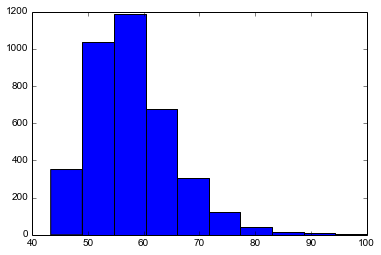

In [18]:
# beer data with multinomial matrix
run_lda('beer', 'input/QC_Beer_ParentsFragments_Tonyscripting.csv', False, n_topics)

In [19]:
# urine data with binary matrix
run_lda('urine37', 'input/Urine_FragmentsParents_MS2filter5000_Tonyscripting.csv', True, n_topics)

Binary input from input/Urine_FragmentsParents_MS2filter5000_Tonyscripting.csv
Data shape (403, 1083)
Fitting model...
DONE!
Writing topics to results/urine37/binary/urine37_binary_topics.csv
Writing fragments x topics probability matrix to results/urine37/binary/urine37_binary_all.csv
Writing topic docs to results/urine37/binary/urine37_binary_docs.csv


Multinomial input from input/Urine_FragmentsParents_MS2filter5000_Tonyscripting.csv
Data shape (403, 1083)
Fitting model...
DONE!
Writing topics to results/urine37/multinomial/urine37_multinomial_topics.csv
Writing fragments x topics probability matrix to results/urine37/multinomial/urine37_multinomial_all.csv
Writing topic docs to results/urine37/multinomial/urine37_multinomial_docs.csv


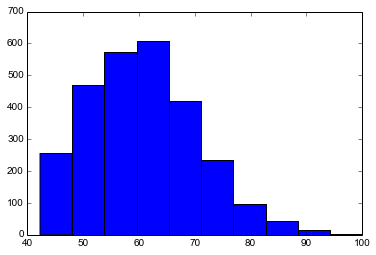

In [20]:
# urine data with multinomial matrix
run_lda('urine37', 'input/Urine_FragmentsParents_MS2filter5000_Tonyscripting.csv', False, n_topics)

In [21]:
# bacterial data with binary matrix
run_lda('campy', 'input/ParentFragmentMatrix_CampyTop10Pos.csv', True, n_topics)

Binary input from input/ParentFragmentMatrix_CampyTop10Pos.csv
Data shape (403, 1083)
Fitting model...
DONE!
Writing topics to results/campy/binary/campy_binary_topics.csv
Writing fragments x topics probability matrix to results/campy/binary/campy_binary_all.csv
Writing topic docs to results/campy/binary/campy_binary_docs.csv


Multinomial input from input/ParentFragmentMatrix_CampyTop10Pos.csv
Data shape (403, 1083)
Fitting model...
DONE!
Writing topics to results/campy/multinomial/campy_multinomial_topics.csv
Writing fragments x topics probability matrix to results/campy/multinomial/campy_multinomial_all.csv
Writing topic docs to results/campy/multinomial/campy_multinomial_docs.csv


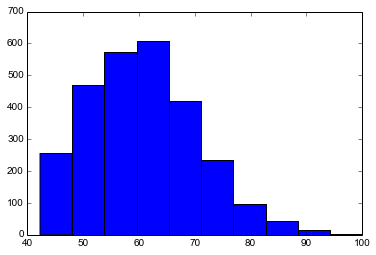

In [22]:
# bacterial data with multinomial matrix
run_lda('campy', 'input/ParentFragmentMatrix_CampyTop10Pos.csv', False, n_topics)

In [23]:
# another urine data with binary matrix
run_lda('urine94', 'input/ParentFragmentMatrix_Urine94_mixed.csv', True, n_topics)

Binary input from input/ParentFragmentMatrix_Urine94_mixed.csv
Data shape (393, 1033)
Fitting model...
DONE!
Writing topics to results/urine94/binary/urine94_binary_topics.csv
Writing fragments x topics probability matrix to results/urine94/binary/urine94_binary_all.csv
Writing topic docs to results/urine94/binary/urine94_binary_docs.csv


Multinomial input from input/ParentFragmentMatrix_Urine94_mixed.csv
Data shape (393, 1033)
Fitting model...
DONE!
Writing topics to results/urine94/multinomial/urine94_multinomial_topics.csv
Writing fragments x topics probability matrix to results/urine94/multinomial/urine94_multinomial_all.csv
Writing topic docs to results/urine94/multinomial/urine94_multinomial_docs.csv


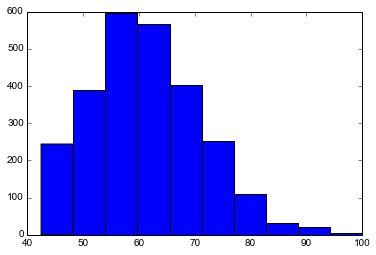

In [24]:
# another urine data with multinomial matrix
run_lda('urine94', 'input/ParentFragmentMatrix_Urine94_mixed.csv', False, n_topics)